# MNIST

## Initialization
### Fetch dataset
This function returns the unsorted MNIST dataset, whereas fetch_mldata() returned the dataset sorted by target (the training set and the test test were sorted separately). In general, this is fine, but if you want to get the exact same results as before, you need to sort the dataset using the following function:

In [4]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [6]:
from sklearn.datasets import fetch_mldata, fetch_openml
import numpy as np
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

#### Examine dataset

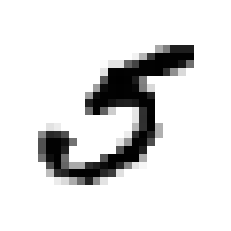

5

In [17]:
X,y = mnist["data"], mnist["target"]
X.shape
y.shape
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()
y[36000]

### Split train and test datesets
Already splitted. (60000 - 10000)

In [18]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#### shuffle to have good random fold for cross validation

In [19]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Make binary classifier for detecting 5

In [20]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### Choose Stochastic Gradient Descent(SGD)

In [22]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([False])

### Implementing Cross validaition to have more control over it

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96045
0.95625
0.97085


#### Evaluating using cross-val-score

In [24]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96045, 0.95625, 0.97085])

### But it's not acceptable -> Dumb classifier

In [26]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90765, 0.91035, 0.91095])

### Calculate confusion matrix
Number of mistakes by some predictions
Get predictions by cross validation predict (Predict every instance in training set)

In [29]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53300,  1279],
       [  970,  4451]])

### Calculate precision and recall

In [32]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.7767888307155323
0.8210662239439218


### Combine precision and recall in one F1 Score metric

In [34]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7983140525513407

### Get decision score and make decision by ourselves

In [40]:
y_scores = sgd_clf.decision_function([X[35000]])
print(y_scores)
threshold = 0 #3500
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

[3035.77524316]


array([ True])

### Get decision scores from cross validation function & Calculate precision recall curve

In [47]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

### Precision recall curve plotter

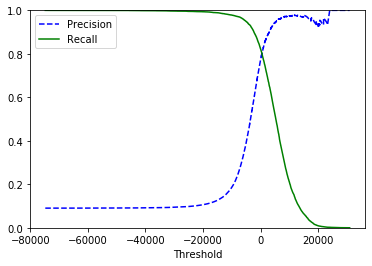

In [48]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### ROC curve

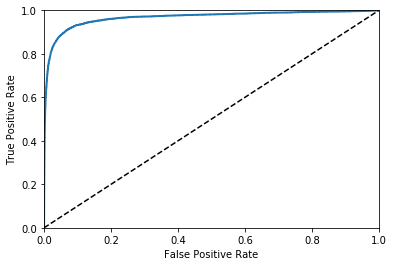

In [50]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plot_roc_curve(fpr, tpr)
plt.show()

### Compute AUC(Area Under Curve)

In [51]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.966708405216852

### Train a random forest and compare it
It doesn't have get_score function instead it has predict_proba().

In [52]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")
y_probas_forest

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([[1. , 0. ],
       [1. , 0. ],
       [0.8, 0.2],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

#### Use positive probabillity as score

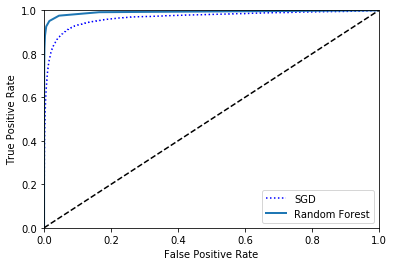

In [56]:
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

## Multiclass classification
If use binary classifiers, sickit learn runs multiple binary classifiers to do that.
### Get scores and get max

In [59]:
sgd_clf.fit(X_train, y_train)  # y_train, not y_train_5
print(sgd_clf.predict([some_digit]))
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

[5]
[[ -6665.34994944 -16840.10543454  -9648.30078344  -3899.88202407
  -14771.73499348  -1387.66733412 -24772.044437   -15747.42580035
  -16099.05977282 -18352.72163478]]


#### Examine some features of this method

In [62]:
np.argmax(some_digit_scores)
sgd_clf.classes_
sgd_clf.classes_[5]

5

#### Force OvO or OvA strategy

In [64]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[5]
45


### Train a random forest classifier

In [67]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5], dtype=int8)

In [68]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. ]])

### Evaluate SGD via cross validation

In [70]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.89262148, 0.86309315, 0.85617843])

#### Improve result by standardize imputs

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

## Error analysis
### Calculate and draw confusion matrix to get some insights

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()